In [1]:
import numpy as np
import evaluate
import torch
import random
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader

from PIL import Image as PILImage
from pathlib import Path
from datasets import load_dataset
from datasets import Dataset, Image

from transformers import ViTImageProcessor
from transformers import ViTForImageClassification
from transformers import ViTFeatureExtractor
from transformers import ViTModel

from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoConfig


In [14]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
model2 = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
model1 = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
model1.eval()
model1.pooler.train()
model1.encoder.layer[0].train()


ViTLayer(
  (attention): ViTSdpaAttention(
    (attention): ViTSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): ViTSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (intermediate): ViTIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): ViTOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)

In [ ]:
model2 = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", add_pooling_layer=False)
model2.eval()
model2.encoder.layer[0].train()

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


None


In [26]:

# model2.eval()
# model2.encoder.layer[0].train()


# y1 = model1(x) ---> y1[1] returns head_outputs + encoder_outputs[1:]
# y2 = model2(x) 

# y3 = MLP(y1[0]) instancia de clasificación
# y4 = MLP(y2[0]) instancia de clasificación

In [27]:

images_path = Path(r'C:\Users\lzuni\Documents\Tesis\database\patches')
labels_path = Path(r'C:\Users\lzuni\Documents\Tesis\database\patch_labels.csv')


images = sorted(list(images_path.glob('*.tiff')), key=lambda x: int(x.stem.split('patch')[-1]))
labels = pd.read_csv(labels_path)
dataset_dict = {'image': [], 'label': []}

for image, label in zip(images, labels['labels']):
    dataset_dict['image'].append(PILImage.open(image))
    label2name = {"1": "NT", "2": "CLE", "3": "PSE"}
    dataset_dict['label'].append(label2name[str(label)])

ds = Dataset.from_dict(dataset_dict )
ds = ds.class_encode_column('label')

splits = ds.train_test_split(test_size=0.2, stratify_by_column='label')
train_ds = splits['train']
test_ds = splits['test']
splits2 = train_ds.train_test_split(test_size=0.2, stratify_by_column='label')
train_ds = splits2['train']
val_ds = splits2['test']


Casting to class labels:   0%|          | 0/168 [00:00<?, ? examples/s]

In [28]:
# Extract label counts for each dataset
train_labels = [int(label) for label in train_ds['label']]
test_labels = [int(label) for label in test_ds['label']]
val_labels = [int(label) for label in val_ds['label']]

In [30]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs


def collate_fn(batch):
    
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    labels = torch.tensor([example["label"] for example in batch])
    return {"pixel_values": pixel_values, "labels": labels}



def compute_metrics(p):
    metric = evaluate.load("accuracy")
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [31]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

model_name = 'google/vit-base-patch32-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

image_mean, image_std = feature_extractor.image_mean, feature_extractor.image_std
size = feature_extractor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            # normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            # normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

C:\Users\lzuni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [32]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)


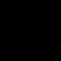

In [98]:
train_ds[7]['image']

In [99]:

id2label = {"0": "NT", "1": "CLE", "2": "PSE"}
label2id = {label:id for id,label in id2label.items()}
config = AutoConfig.from_pretrained(model_name, label2id=label2id, id2label=id2label)

model = ViTForImageClassification.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [101]:


training_args = TrainingArguments(
  output_dir="./vit-base-patches",
  use_cpu=True,
  per_device_train_batch_size=4,
  per_device_eval_batch_size= 1,
  eval_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=4,
  # weight_decay=0.01,
  fp16=True,
  # save_steps=100,
  # eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=feature_extractor,
)

In [102]:
trainer.train()
# train_results = trainer.train()
# # trainer.save_model()
# trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
# trainer.save_state()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.979200,0.770187,0.592593
2,0.919100,0.909654,0.481481
3,0.925900,0.703723,0.629630
4,0.892200,0.700396,0.629630


TrainOutput(global_step=108, training_loss=0.8923925073058517, metrics={'train_runtime': 97.8998, 'train_samples_per_second': 4.372, 'train_steps_per_second': 1.103, 'total_flos': 3.3807228049760256e+16, 'train_loss': 0.8923925073058517, 'epoch': 4.0})

In [103]:
metrics = trainer.evaluate(val_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.6296
  eval_loss               =     0.7004
  eval_runtime            = 0:00:03.27
  eval_samples_per_second =       8.24
  eval_steps_per_second   =       8.24


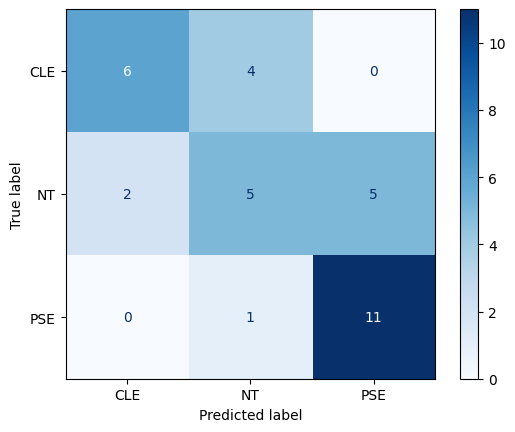

In [104]:
from PIL import Image
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(test_ds)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = test_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")

    